<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>


В этом задании вам предстоит решить задачу сегментации медицинских снимков. Часть кода с загрузкой данных написана за вас. Всю содержательную сторону вопроса вам нужно заполнить самостоятельно. Задание оценивается из 15 баллов. 

Обратите внимание, что отчёт по заданию стоит целых 6 баллов. Он вынесен в отдельный пункт в конце тетради. Это сделано для того, чтобы тетрадь была оформлена как законченный документ о проведении экспериментов. Неотъемлемой составляющей отчёта является ответ на следующие вопросы:

* Что было сделано? Что получилось реализовать, что не получилось?
* Какие результаты ожидалось получить?
* Какие результаты были достигнуты?
* Чем результаты различных подходов отличались друг от друга и от бейзлайна (если таковой присутствует)?




---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>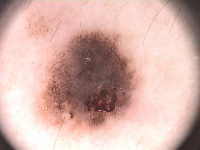</td><td>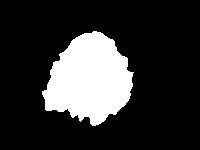</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

Библиотеки

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
from torchvision import models

import matplotlib.pyplot as plt
from IPython.display import clear_output
from skimage.io import imread
from skimage.transform import resize
from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

import os
from time import time
import warnings
warnings.filterwarnings("ignore")

Воспроизводимость

In [2]:
SEED = 0
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [3]:
images = []
lesions = []
root = '../input/ph2dataset/PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [4]:
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [5]:
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [6]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

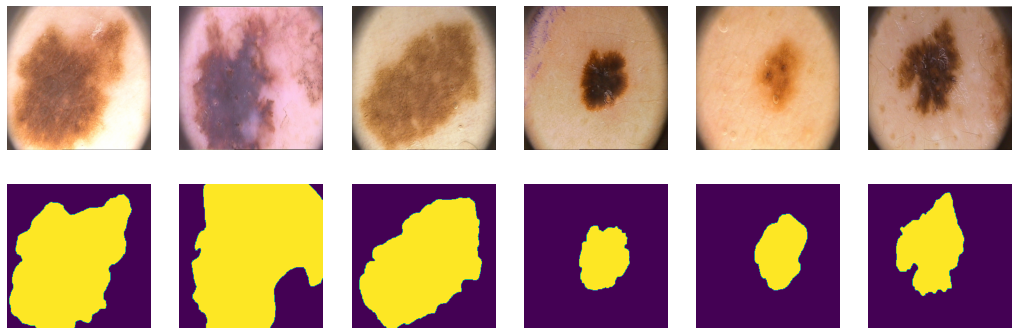

In [7]:
plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [8]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [9]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [10]:
batch_size = 10
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

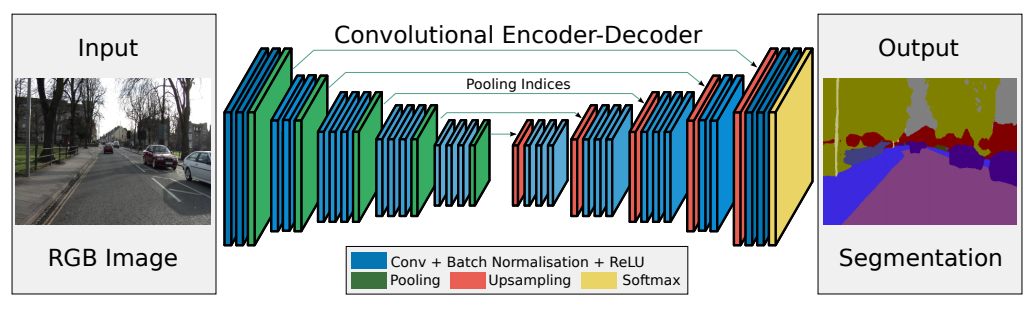

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

Так как декодер сети SegNet имеет такую же архитекруту, как VGG16, распечатаем модель

In [12]:
from torchvision.models import vgg16

vgg = vgg16()
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [13]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 256 -> 128
        
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.pool1 =  nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 128 -> 64
        
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 64 -> 32
        
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.pool3 =  nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 32 -> 16

        self.enc_conv4 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.pool4 =  nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 16 -> 8

        # decoder (upsampling)
        self.upsample4 = nn.MaxUnpool2d(kernel_size=2, stride=2, padding=0) # 8 -> 16
        self.dec_conv4 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        
        self.upsample3 = nn.MaxUnpool2d(kernel_size=2, stride=2, padding=0) # 16 -> 32
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        
        self.upsample2 = nn.MaxUnpool2d(kernel_size=2, stride=2, padding=0) # 32 -> 64
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        
        self.upsample1 = nn.MaxUnpool2d(kernel_size=2, stride=2, padding=0) # 64 -> 128
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2, stride=2, padding=0) # 128 -> 256
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=3, padding=1) # в сегментации 2 класса
        )

    def forward(self, x):
        # encoder
        x, indices_0 = self.pool0(self.enc_conv0(x))
        x, indices_1 = self.pool1(self.enc_conv1(x))
        x, indices_2= self.pool2(self.enc_conv2(x))
        x, indices_3 = self.pool3(self.enc_conv3(x)) 
        x, indices_4 = self.pool4(self.enc_conv4(x))
    
        # decoder
        # ширина и высота у 'e_3' и 'self.enc_conv4(e_3)' одинаковые
        x = self.dec_conv4(self.upsample4(x, indices_4))
        x = self.dec_conv3(self.upsample3(x, indices_3))
        x = self.dec_conv2(self.upsample2(x, indices_2))
        x = self.dec_conv1(self.upsample1(x, indices_1))
        x = self.dec_conv0(self.upsample0(x, indices_0)) # no activation
        
        return x

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [14]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # 

## Функция потерь [1 балл]

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [15]:
def bce_loss(y_pred, y_real):
    return (y_pred - y_real*y_pred + torch.log(1 + torch.exp(-y_pred))).mean()

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [16]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    train_loss_history = []
    val_loss_history = []
    X_val, Y_val = next(iter(data_val))

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))
        
        # TRAINING
        avg_train_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_pred, Y_batch) # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_train_loss += loss / len(data_tr)
        toc = time()
        train_loss_history.append(round(avg_train_loss.item(), 4))
        print(f'train loss: {avg_train_loss:.4f}')

        #VALIDATION
        avg_val_loss = 0
        model.eval()
        for X_batch, Y_batch in data_val:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            
            with torch.no_grad():
                Y_pred = model(X_batch)
                loss = loss_fn(Y_pred, Y_batch)
                avg_val_loss += loss / len(data_val)
        val_loss_history.append(round(avg_val_loss.item(), 4))
        print(f'val loss: {avg_val_loss:.4f}')
        
        # show intermediate results
        model.eval()  # testing mode
        # detach and put into cpu
        X_val = X_val.to(device)
        Y_hat = model(X_val).detach().cpu()
        X_val = X_val.cpu()

        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_train_loss))
        plt.show()
        
    return train_loss_history, val_loss_history

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [17]:
def predict(model, X_batch):
    """
    Returns segmentation for a batch of images
    """
    model.eval()  
    X_batch = X_batch.to(device)
    with torch.no_grad():
        Y_pred = model(X_batch).cpu()
    Y_pred = (Y_pred > 0).float()
    return Y_pred

In [18]:
def score_model(model, metric, data):
    """
    Scores the model on data
    """
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = predict(model, X_batch)
        scores += metric(Y_pred, Y_label).mean().item()

    return round(scores/len(data), 4)

In [19]:
# будем записывать в словари результаты работы сетей с разными лоссами
train_losses = {}
val_losses = {}
scores = {}

In [20]:
def draw_losses(train_loss, val_loss, title):
    """
    Функция для отрисовки лоссов
    """
    plt.plot(train_loss, label='train')
    plt.plot(val_loss, label='valid')
    plt.grid()
    plt.title(f'Графики loss-ов ({title})')
    plt.legend();

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


### SegNet, bce_loss

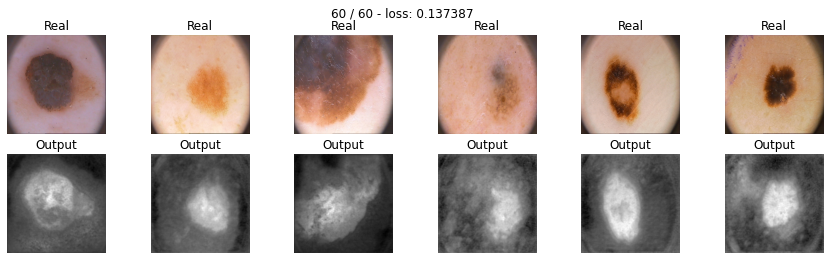

In [21]:
model = SegNet().to(device)

max_epochs = 60
optimizer = optim.Adam(model.parameters())
results = train(model, optimizer, bce_loss, max_epochs, data_tr, data_val)

train_losses['segnet_bce'], val_losses['segnet_bce'] = results

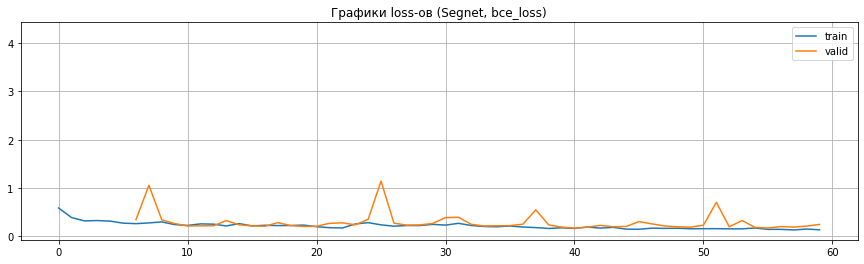

In [22]:
draw_losses(train_losses['segnet_bce'], val_losses['segnet_bce'], 'Segnet, bce_loss')

Оценка модели

In [23]:
scores['segnet_bce'] = score_model(model, iou_pytorch, data_val)
scores['segnet_bce']

0.656

Iou-метрика дает 0.6. Решая обратно уравнение $2(x-0.5) = 0.6$, получаем, что в среднем для каждого изображения intersection/union = 0.8. "Оценим глазами" результаты

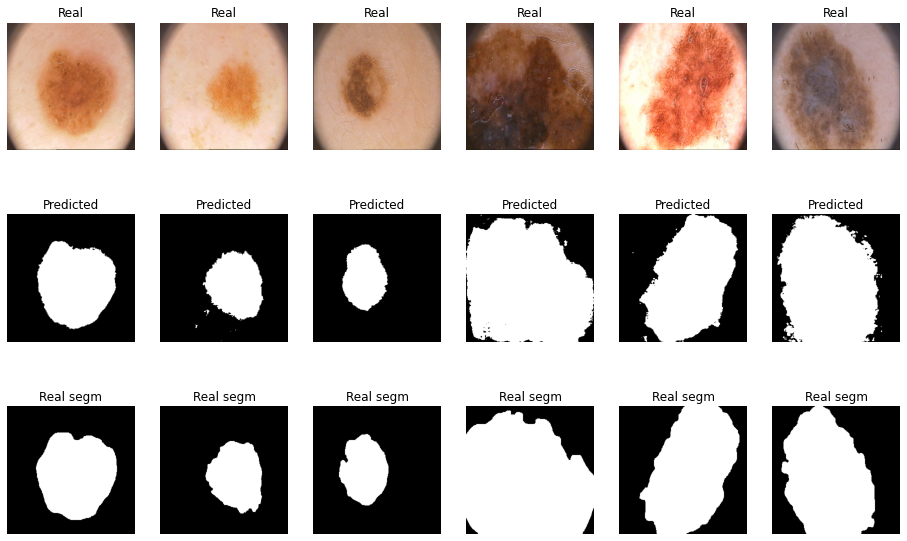

In [24]:
X_batch, Y_real = next(iter(data_val))
Y_pred = predict(model, X_batch)

plt.figure(figsize=(16,10))
for k in range(6):
    plt.subplot(3, 6, k+1)
    plt.imshow(np.rollaxis(X_batch[k].numpy(), 0, 3), cmap='gray')
    plt.title('Real')
    plt.axis('off')

    plt.subplot(3, 6, k+7)
    plt.imshow(np.rollaxis(Y_pred[k].numpy(), 0, 3), cmap='gray')
    plt.title('Predicted')
    plt.axis('off')
    
    plt.subplot(3, 6, k+13)
    plt.imshow(np.rollaxis(Y_real[k].numpy(), 0, 3), cmap='gray')
    plt.title('Real segm')
    plt.axis('off')
plt.show()

Ответьте себе на вопрос: не переобучается ли моя модель?

Модель стабилизируется. Модель не переобучается, так как до 40й эпохи лосс продолжал падать.

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла] 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss. 
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало эпох, прежде чем бить тревогу попробуйте перебрать различные варианты и убедитесь, что во всех других сетапах сеть достигает желанного результата. СПОЙЛЕР: учиться она будет при всех лоссах, предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \frac{\sum_i2X_iY_i}{\sum_iX_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [25]:
def dice_loss(y_pred, y_real):
    SMOOTH = 1e-8
    num = 2*(torch.sigmoid(y_pred)*y_real).sum(dim=(-1,-2)) + SMOOTH
    den = (torch.sigmoid(y_pred) + y_real).sum(dim=(-1,-2)) + SMOOTH
    res = (1 - (1/(256*256))*num/den).mean()
    return res 

### SegNet, dice_loss

Проводим тестирование:

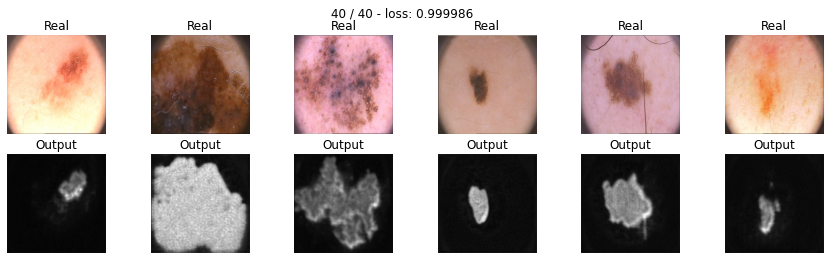

In [26]:
model_dice = SegNet().to(device)

max_epochs = 40
optimizer = optim.Adam(model_dice.parameters())
results = train(model_dice, optimizer, dice_loss, max_epochs, data_tr, data_val)

train_losses['segnet_dice'], val_losses['segnet_dice'] = results

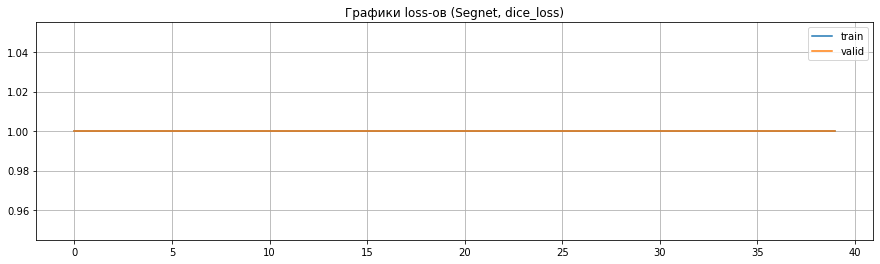

In [27]:
draw_losses(train_losses['segnet_dice'], val_losses['segnet_dice'], 'Segnet, dice_loss')

In [28]:
scores['segnet_dice'] = score_model(model_dice, iou_pytorch, data_val)
scores['segnet_dice']

0.682

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [29]:
def focal_loss(y_pred, y_real, eps=1e-8, gamma=2):
    y_prob = torch.clamp(torch.sigmoid(y_pred), min=1e-8)
    y_reverse_prob = torch.clamp(1 - y_prob, min=1e-8) # 1-1e-8 = 1 using torch, here we fix it
    
    loss = - (torch.pow(y_reverse_prob, gamma)*y_real*torch.log(y_prob) + \
        (1-y_real)*torch.log(y_reverse_prob)).mean()
    return loss

### SegNet, focal_loss

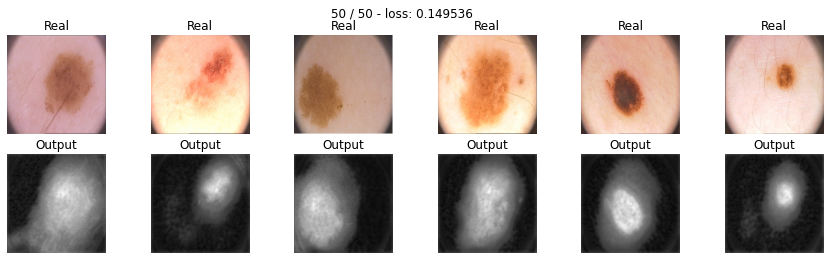

In [55]:
model_focal = SegNet().to(device)

max_epochs = 50
optimizer = optim.Adam(model_focal.parameters())
results = train(model_focal, optimizer, focal_loss, max_epochs, data_tr, data_val)

train_losses['segnet_focal'], val_losses['segnet_focal'] = results

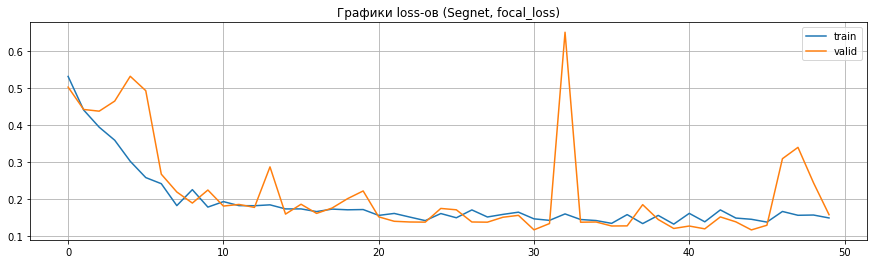

In [56]:
draw_losses(train_losses['segnet_focal'], val_losses['segnet_focal'], 'Segnet, focal_loss')

In [57]:
scores['segnet_focal'] = score_model(model_focal, iou_pytorch, data_val)
scores['segnet_focal']

0.596

----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты? 

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Любой другой 

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

Так как Тверский лосс очень похож на данные выше, то за него будет проставлено только 3 балла (при условии, если в модели нет ошибок при обучении). Постарайтесь сделать что-то интереснее.

In [33]:
# <TODO>

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

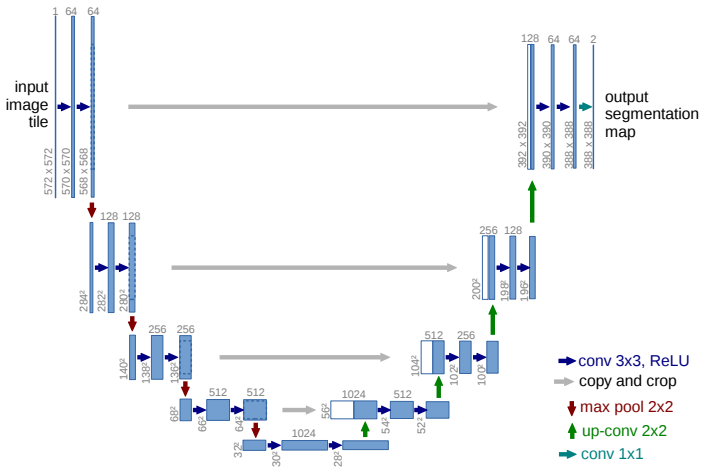

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [34]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2) # 256 -> 128
        
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 128 -> 64
        
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # 64 -> 32
        
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )        
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        # decoder (upsampling)
        self.upsample3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2, padding=0) # 16 -> 32
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.upsample2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2, padding=0) # 32 -> 64
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.upsample1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2, padding=0) # 64 -> 128
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.upsample0 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2, padding=0) # 128 -> 256
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        ) 
        self.outp_conv = nn.Conv2d(32, 1, kernel_size=1, padding=0)

    def forward(self, x):
        # encoder
        e_0 = self.enc_conv0(x)
        x = self.pool0(e_0)
        e_1 = self.enc_conv1(x)
        x = self.pool1(e_1)
        e_2 = self.enc_conv2(x)
        x = self.pool2(e_2)
        e_3 = self.enc_conv3(x)
        x = self.pool3(e_3)
        
        # bottleneck
        x = self.bottleneck_conv(x)

        # decoder
        x = self.upsample3(x)
        x = torch.cat([e_3, x], axis=1)
        x = self.dec_conv3(x)
        
        x = self.upsample2(x)
        x = torch.cat([e_2, x], axis=1)
        x = self.dec_conv2(x)
        
        x = self.upsample1(x)
        x = torch.cat([e_1, x], axis=1)
        x = self.dec_conv1(x)
        x = self.upsample0(x)
        x = torch.cat([e_0, x], axis=1)
        x = self.dec_conv0(x)
        
        x = self.outp_conv(x) # no activation
        return x

### UNet, bce_loss

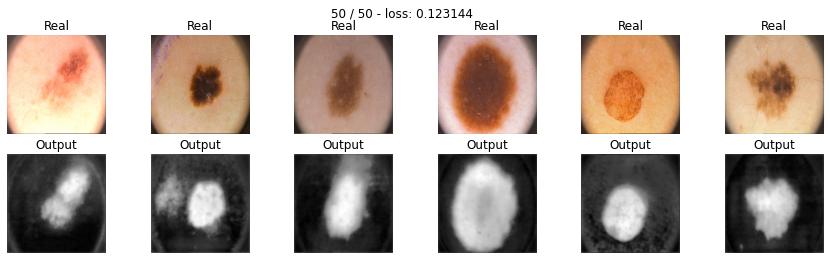

In [35]:
unet_model = UNet().to(device)

max_epochs = 50
optimizer = optim.Adam(unet_model.parameters())
results = train(unet_model, optimizer, bce_loss, max_epochs, data_tr, data_val)

train_losses['unet_bce'], val_losses['unet_bce'] = results

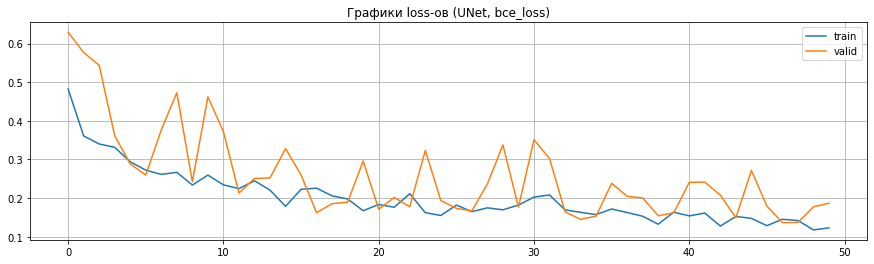

In [36]:
draw_losses(train_losses['unet_bce'], val_losses['unet_bce'], 'UNet, bce_loss')

In [37]:
scores['unet_bce'] = score_model(unet_model, iou_pytorch, data_val)
scores['unet_bce']

0.698

### UNet, dice_loss

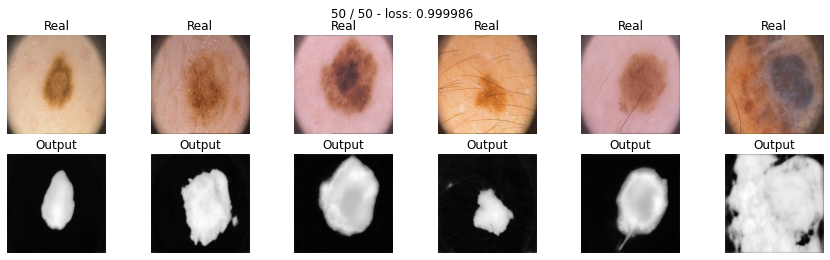

In [38]:
unet_model_dice = UNet().to(device)

max_epochs = 50
optimizer = optim.Adam(unet_model_dice.parameters())
results = train(unet_model_dice, optimizer, dice_loss, max_epochs, data_tr, data_val)

train_losses['unet_dice'], val_losses['unet_dice'] = results

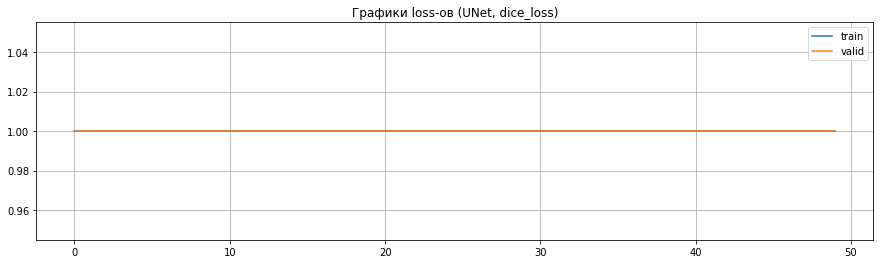

In [39]:
draw_losses(train_losses['unet_dice'], val_losses['unet_dice'], 'UNet, dice_loss')

In [40]:
scores['unet_dice'] = score_model(unet_model_dice, iou_pytorch, data_val)
scores['unet_dice']

0.766

UNet, focal_loss

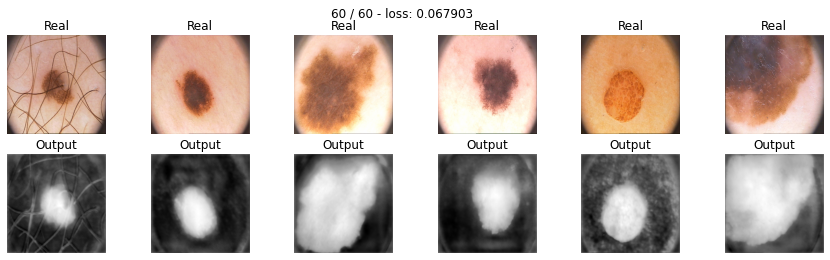

In [58]:
unet_model_focal = UNet().to(device)

max_epochs = 60
optimizer = optim.Adam(unet_model_focal.parameters())
results = train(unet_model_focal, optimizer, focal_loss, max_epochs, data_tr, data_val)

train_losses['unet_focal'], val_losses['unet_focal'] = results

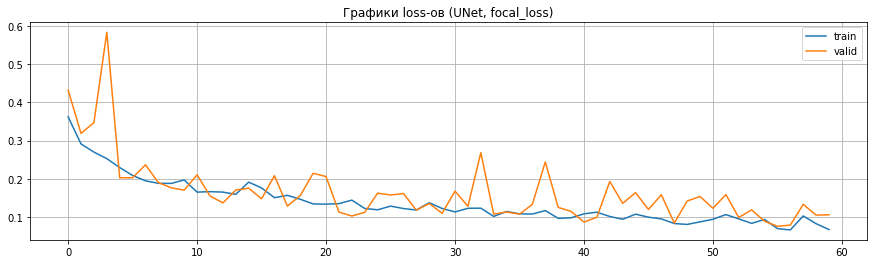

In [59]:
draw_losses(train_losses['unet_focal'], val_losses['unet_focal'], 'UNet, focal_loss')

In [60]:
scores['unet_focal'] = score_model(unet_model_focal, iou_pytorch, data_val)
scores['unet_focal']

0.754

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


**NOTE:** Выше в задании написано что-то странное (заменить max-pool на convolution? при этом выше написано другое? написано, что надо поменять kernel_size для max_pool).

Поэтому в итоге 
1) Изменено ядро max-pool (2-->3)

2) ConvTranspose2d(kernel_size=2, stride=2) изменено на Upsampling с последующей конволюцией с kernel_size=3 (при использовании kernel_size=2, padding размер выхода картинки не такой, какой нужно). После Upsampling используется конволюция, чтобы получить нужное число каналов

In [44]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()
        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.pool0 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1) # 256 -> 128
        
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1) # 128 -> 64
        
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1) # 64 -> 32
        
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )        
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        # decoder (upsampling)
        self.upsample3 = nn.Sequential(
            nn.Upsample(32),
            nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1)
        ) # 16 -> 32
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        
        self.upsample2 = nn.Sequential(
            nn.Upsample(64),
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1)
        ) # 32 -> 64
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        
        self.upsample1 = nn.Sequential(
            nn.Upsample(128),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1)
        ) # 64 -> 128
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        
        self.upsample0 = nn.Sequential(
            nn.Upsample(256),
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
        ) # 128 -> 256
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        ) 
        
        self.outp_conv = nn.Conv2d(32, 1, kernel_size=1, padding=0)

    def forward(self, x):
        # encoder
        e_0 = self.enc_conv0(x)
        x = self.pool0(e_0)
        e_1 = self.enc_conv1(x)
        x = self.pool1(e_1)
        e_2 = self.enc_conv2(x)
        x = self.pool2(e_2)
        e_3 = self.enc_conv3(x)
        x = self.pool3(e_3)
        
        # bottleneck
        x = self.bottleneck_conv(x)

        # decoder
        x = self.upsample3(x)
        x = torch.cat([e_3, x], axis=1)
        x = self.dec_conv3(x)
        
        x = self.upsample2(x)
        x = torch.cat([e_2, x], axis=1)
        x = self.dec_conv2(x)
        
        x = self.upsample1(x)
        x = torch.cat([e_1, x], axis=1)
        x = self.dec_conv1(x)
        
        x = self.upsample0(x)
        x = torch.cat([e_0, x], axis=1)
        x = self.dec_conv0(x)
        
        x = self.outp_conv(x) # no activation
        return x

### UNet2, bce_loss

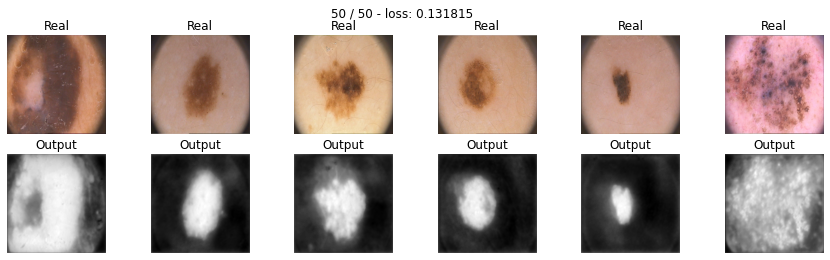

In [45]:
unet2_model = UNet2().to(device)

max_epochs = 50
optimizer = optim.Adam(unet2_model.parameters())
results = train(unet2_model, optimizer, bce_loss, max_epochs, data_tr, data_val)

train_losses['unet2_bce'], val_losses['unet2_bce'] = results

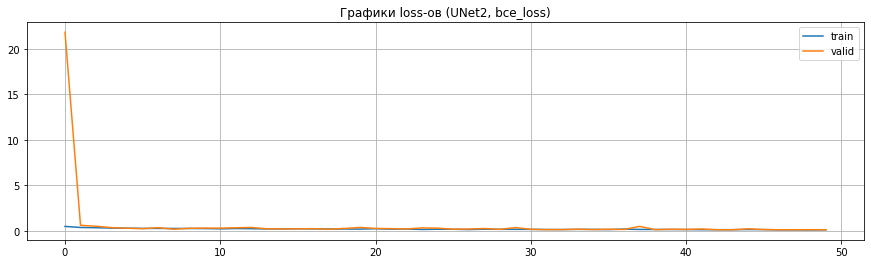

In [46]:
draw_losses(train_losses['unet2_bce'], val_losses['unet2_bce'], 'UNet2, bce_loss')

In [47]:
scores['unet2_bce'] = score_model(unet2_model, iou_pytorch, data_val)
scores['unet2_bce']

0.778

### UNet, dice_loss

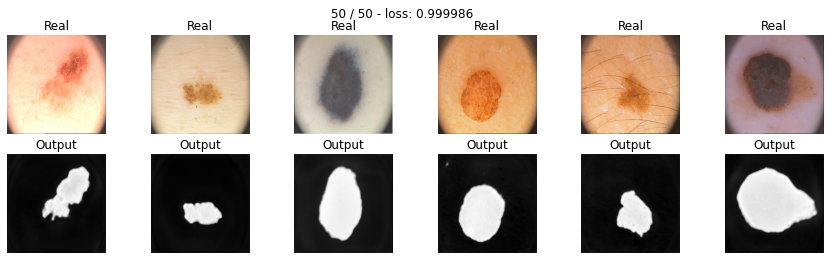

In [48]:
unet2_model_dice = UNet2().to(device)

max_epochs = 50
optimizer = optim.Adam(unet2_model_dice.parameters())
results = train(unet2_model_dice, optimizer, dice_loss, max_epochs, data_tr, data_val)

train_losses['unet2_dice'], val_losses['unet2_dice'] = results

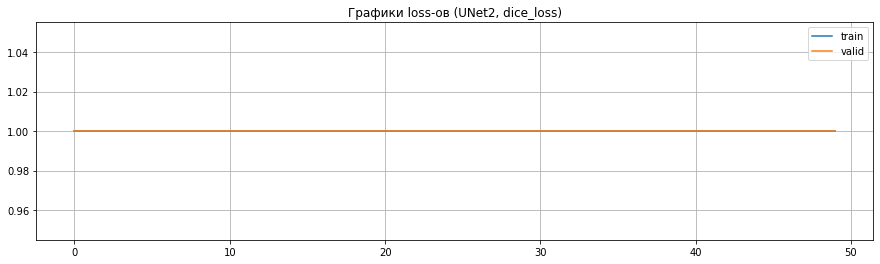

In [49]:
draw_losses(train_losses['unet2_dice'], val_losses['unet2_dice'], 'UNet2, dice_loss')

In [50]:
scores['unet2_dice'] = score_model(unet2_model_dice, iou_pytorch, data_val)
scores['unet2_dice']

0.782

### UNet2, focal_loss

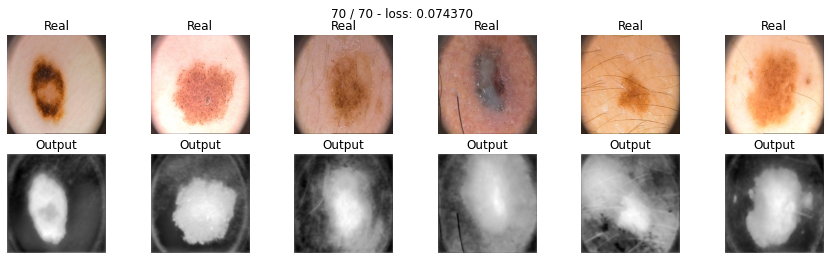

In [51]:
unet2_model_focal = UNet2().to(device)

max_epochs = 70
optimizer = optim.Adam(unet2_model_focal.parameters())
results = train(unet2_model_focal, optimizer, focal_loss, max_epochs, data_tr, data_val)

train_losses['unet2_focal'], val_losses['unet2_focal'] = results

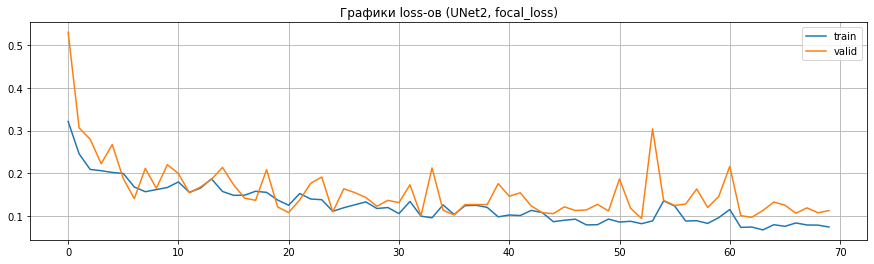

In [52]:
draw_losses(train_losses['unet2_focal'], val_losses['unet2_focal'], 'UNet2, focal_loss')

In [53]:
scores['unet2_focal'] = score_model(unet2_model_focal, iou_pytorch, data_val)
scores['unet2_focal']

0.686

Сделайте вывод, какая из моделей лучше

# Отчет (6 баллов): 
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте. 
Если вы пропустили какую-то часть в задании выше, то вы все равно можете получить основную часть баллов в отчете, если правильно зададите проверяемые вами гипотезы.


Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверяющий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.

Дополнительные комментарии: 

Пусть у вас есть N обученных моделей.
- Является ли отчетом N графиков с 1 линей? Да, но очень низкокачественным, потому что проверяющий не сможет сам сравнить их.

- Является ли отчетом 1 график с N линиями? Да, но скорее всего таким образом вы отразили лишь один эффект. Этого мало, чтобы сделать досточно суждений по поводу вашей работа.

- Я проверял метрики на трейне, и привел в результате таблицу с N числами, что не так? ключейвой момент тут, что вы измеряли на трейне ваши метрики, уверены ли вы, что заивисмости останутся такими же на отложенной выборке?

- Я сделал отчет содержащий график лоссов и метрик, и у меня нет ошибок в основной части, но за отчет не стоит максимум, почему? Естестественно максимум баллов за отчет можно получить не за 2 графика (даже при условии их полной правильности). Проверяющий хочет видеть больше сравнений моделей, чем метрики и лоссы (особенно, если они на трейне).

Советы: попробуйте правильно поставить вопрос на который вы себе отвечаете и продемонстрировать таблицу/график, помогающий проверяющему увидеть ответ на этот вопрос. Пример: Ваня хочет узнать, с каким из 4-х лоссов модель (например, U-Net) имеет наилучшее качество. Что нужно сделать Ване? Обучить 4 одинаковых модели с разными лосс функциями. И измерить итогововое качество. Продемонстрировать результаты своих измерений и итоговый вывод. (warning: конечно же, это не идеально ответит на наш вопрос, так как мы не учитываем в экспериментах возможные различные типы ошибок, но для первого приближения этого вполне достаточно).

Примерное время на подготовку отчета 1 час, он содержит сравнение метрик, график лоссов, выбор лучших моделей из нескольких кластеров и выбор просто лучшей модели, небольшой вывод по всему дз, возможно сравнение результирующих сегментаций, времени или числа параметров модели, проявляйте креативность.

У нас есть три архитектуры: SegNet, UNet и UNet2. Архитектура SegNet переводит 3х-канальное изображение в 64 канала и на каждом слое удваивает их. Архитектуры UNet и UNet2 переводят 3 канала в 32, но при этом используют skip connection (как в https://pytorch.org/hub/mateuszbuda_brain-segmentation-pytorch_unet/). Также у нас есть 3 лосс-функции: bce_loss, dice_loss, focal_loss. Используя каждую архитектуру и лосс-функцию, мы получаем 9 моделей.

Рассмотрим графики лоссов для разных архитектур 

Графики лоссов моделей с dice_loss нерепрезентативны, loss колеблется около единицы, поэтому эти модели мы будем оценивать только по метрике IOU.

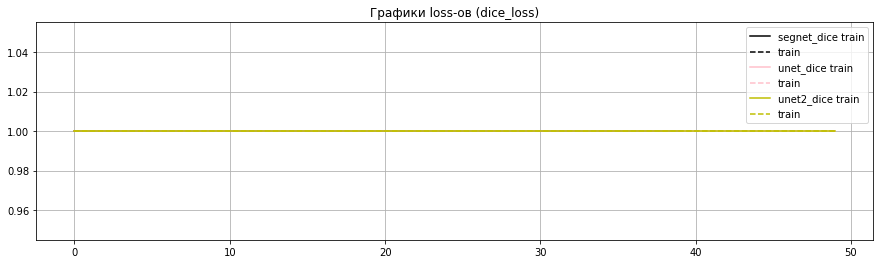

In [106]:
for i, model in enumerate(scores.keys()):
    if not model.endswith('dice'):
        continue
    plt.plot(range(len(train_losses[model])), train_losses[model], label=f'{model} train', c=colors[i])
    plt.plot(val_losses[model], label='train', c=colors[i], ls='--')
    plt.grid()
    plt.title('Графики loss-ов (dice_loss)')
    plt.legend();

Рассмотрим остальные модели

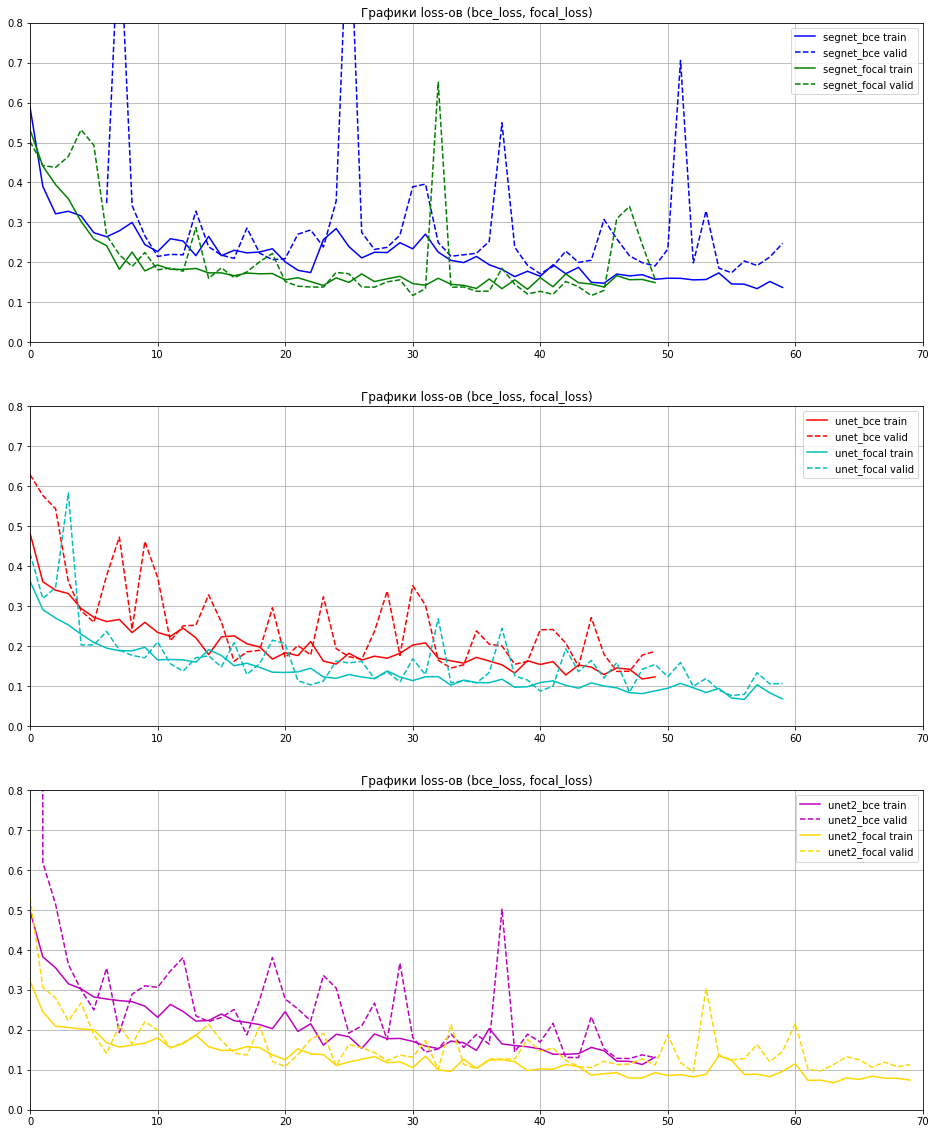

In [121]:
models = list(scores.keys())
colors = ['b', 'k', 'g', 'r', 'pink', 'c', 'm', 'y', 'gold']

plt.figure(figsize=(16,20))
for i, model in enumerate(scores.keys()):
    if model.endswith('dice'):
        continue
    plt.subplot(3, 1, i//3+1)
    plt.plot(train_losses[model], label=f'{model} train', c=colors[i])
    plt.plot(val_losses[model], label=f'{model} valid', c=colors[i], ls='--')
    plt.grid()
    plt.title('Графики loss-ов (bce_loss, focal_loss)')
    plt.xlim(0, 70)
    plt.ylim(0, 0.8)
    plt.grid(True)
    plt.legend();

По этим графикам мы можем сделать вывод, что лосс падает чуть лучше у моделей с focal_loss, чем с bce_loss. Также мы видим, что модели, использующие SenNet архитектуру, чуть хуже, чем модели с UNet и UNet2, которые показывают похожие результаты

Посмотрим на метрику

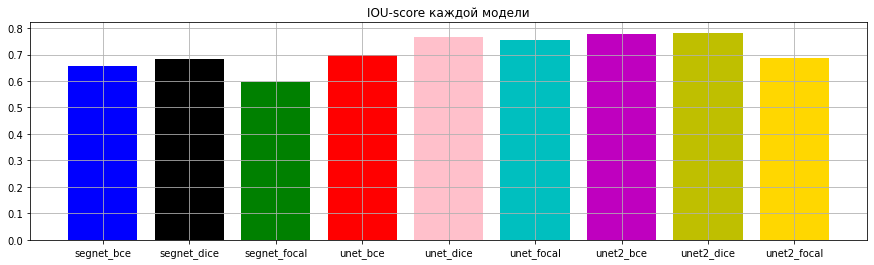

In [126]:
scores_list = list(scores.values())

plt.bar(models, scores_list, color=colors)
plt.title('IOU-score каждой модели')
plt.grid(True)

In [70]:
scores

{'segnet_bce': 0.656,
 'segnet_dice': 0.682,
 'segnet_focal': 0.596,
 'unet_bce': 0.698,
 'unet_dice': 0.766,
 'unet_focal': 0.754,
 'unet2_bce': 0.778,
 'unet2_dice': 0.782,
 'unet2_focal': 0.686}

Хоть лоссы и меньше для моделей, использующих focal_loss, метрика показывает немного другие результаты. Это можно связать с тем, что при расчете метрики предсказания моделей бинаризируются.
По метрикам опять же, SegNet модели хуже остальных.

### Согласно метрике, лучшими моделями мы будем считать UNet2 и использованием bce_loss и dice_loss